# Anomnaly Detection

This notebook was created as an extension to the `evaluate_detection.py` script.

In [1]:
# import
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from fault_management_uds.plots import visualize_confusion, visualize_roc_auc, visualize_metric_matrix
from fault_management_uds.config import data_label_hue_map, data_label_hue_order, anomaly_hue_map, anomaly_hue_order


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR
from fault_management_uds.config import rain_gauge_color, condition_to_meta

2025-02-24 19:02:57.293 | INFO     | fault_management_uds.config:<module>:15 - PROJ_ROOT path is: /work3/s194262/GitHub/fault_management_uds
2025-02-24 19:02:58.892441: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 19:02:59.626799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740420179.712740  722429 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740420179.737012  722429 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
20

In [46]:
model_save_path = 'transformer/7_anomalous/iteration=0_250206_0903'
data_type = 'val'  

anomalous_path = MODELS_DIR / model_save_path / '1_split' / 'anomalous'
results_folder = anomalous_path / data_type

eval_path = MODELS_DIR / model_save_path / '1_split' / 'evaluation'
eval_folder = eval_path / data_type


In [47]:
# Load the results
with open(results_folder / 'anomaly_prediction_results_full.pkl', 'rb') as f:
    results = pickle.load(f)

print(results.keys())

dict_keys(['Valid index', 'Starttime', 'Data label', 'Actual', 'Combined', 'Target', 'Residuals', 'Final hidden', 'IG'])


In [48]:
# rename the key in dict
results['Final Hidden'] = results.pop('Final hidden')
results['Multi-Feature'] = results.pop('Combined')
results['Data Label'] = results.pop('Data label')

In [49]:
methods = ['Target', 'Final Hidden', 'Residuals', 'IG', 'Multi-Feature']

In [50]:
# set save folder
save_folder = eval_folder / 'anomaly_detection'
os.makedirs(save_folder, exist_ok=True)

# Thresholding

In [51]:
if data_type == 'val':
    optimal_thresholds = {}
    for i, key in enumerate(methods):
        # ROC curve
        fpr, tpr, thresholds = roc_curve(results['Actual'], results[key]['Decision Function'])

        # Don't use the first and last threshold
        fpr = fpr[1:-1]
        tpr = tpr[1:-1]
        thresholds = thresholds[1:-1]

        # Calculate Youden's index
        youden_index = tpr - fpr
        optimal_threshold = thresholds[np.argmax(youden_index)]

        print(f'Optimal Threshold for {key}: {optimal_threshold}')
        optimal_thresholds[key] = optimal_threshold

    # Save the optimal thresholds
    with open(anomalous_path / 'optimal_thresholds.pkl', 'wb') as f:
        pickle.dump(optimal_thresholds, f)

# Load the optimal thresholds, ensure they exist
if os.path.exists(anomalous_path / 'optimal_thresholds.pkl'):
    with open(anomalous_path / 'optimal_thresholds.pkl', 'rb') as f:
        optimal_thresholds = pickle.load(f)
else:
    raise FileNotFoundError('Optimal thresholds not found')

# insert the optimal threshold to the results
for key in methods:
    results[key]['Optimal Threshold'] = optimal_thresholds[key]
    # Update the predicted labels
    results[key]['Predicted'] = results[key]['Decision Function'] > optimal_thresholds[key]

Optimal Threshold for Target: 0.045446631864508036
Optimal Threshold for Final Hidden: 0.17253181202457324
Optimal Threshold for Residuals: 0.136440749578284
Optimal Threshold for IG: -0.046551006196230205
Optimal Threshold for Multi-Feature: -0.02653451620469699


# Sigma-3

In [52]:
# add the sigma-3 results
starttimes = pd.to_datetime(results['Starttime'])

with open(eval_folder / f'output.pkl', 'rb') as f:
    output = pickle.load(f)

timestamps = output['timestamps']
# use only the first step

residuals = abs(output['predictions'][:,:,0].flatten() - output['targets'][:,:,0].flatten())

# extract relevant residuals based on the starttimes
residuals = residuals[np.isin(timestamps, starttimes)]

# mask = np.in1d(timestamps, starttimes)  # Create a boolean mask
# residuals = residuals[mask]  # Apply the mask to extract relevant residuals

# starttimes_set = set(starttimes)
# mask = np.array([ts in starttimes_set for ts in timestamps])
# residuals = residuals[mask]

# use the 3-sigma rule to determine the anomalies
sigma = 3
mean = np.mean(residuals)
std = np.std(residuals)

results['Sigma-3'] = {
    'Predicted': residuals > mean + sigma * std,
    'Decision Function': residuals,
    'Optimal Threshold': mean + sigma * std
}


methods = methods + ['Sigma-3']

# Confusion Matrix

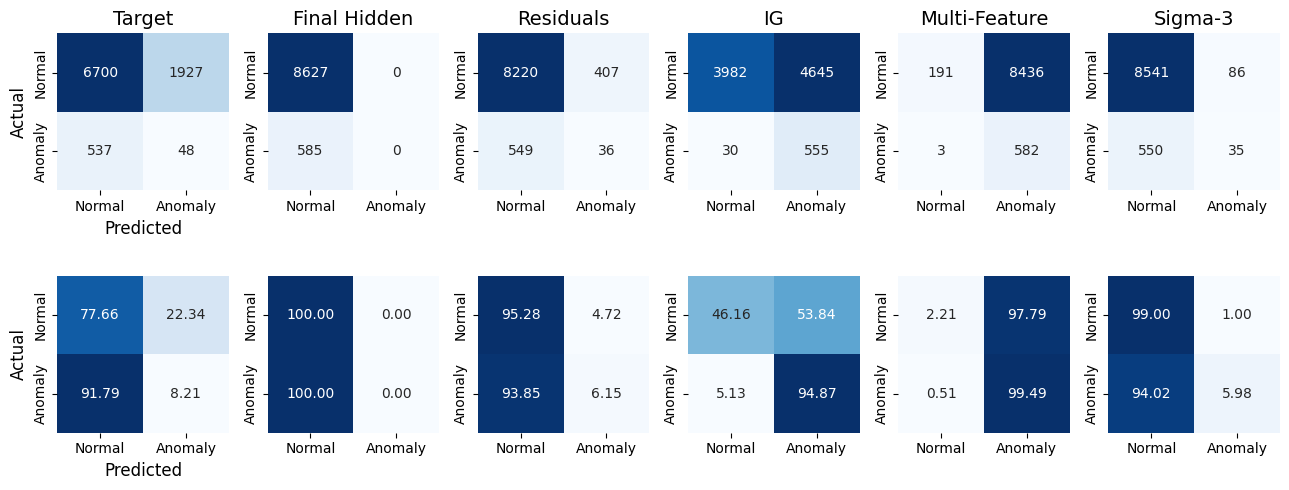

In [33]:
# Overall results
fig, axes = plt.subplots(2, len(methods), figsize=(13, 5))
auc_scores = {}
for i, key in enumerate(methods):
    # Confusion matrix
    conf_matrix = confusion_matrix(results['Actual'], results[key]['Predicted'])
    axes[0, i] = visualize_confusion(axes[0, i], i, key, conf_matrix, 'd', 'Blues')
    # add header
    # Percentage confusion matrix
    conf_matrix = confusion_matrix(results['Actual'], results[key]['Predicted'])
    conf_matrix = conf_matrix.astype('float') / (conf_matrix.sum(axis=1)[:, np.newaxis] + 1e-9) * 100
    axes[1, i] = visualize_confusion(axes[1, i], i, ' ', conf_matrix, ".2f", 'Blues')

plt.tight_layout()
plt.savefig(save_folder / 'cm_overall.png')
plt.show()
plt.close()

# ROC Curve

In [67]:
def visualize_roc_auc(ax, i, key, fpr, tpr, roc_auc, optimal_fpr=None, optimal_tpr=None):   
    ax.plot(fpr, tpr, color='darkorange', lw=2, label="ROC")#, label='AUC: %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--', label='Random')
    # plot optimal if specified
    if optimal_fpr is not None and optimal_tpr is not None:
        ax.plot(optimal_fpr, optimal_tpr, marker='o', markersize=4, color='navy', label='Threshold')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    if i == 0:
        ax.set_ylabel('TPR', fontsize=12)
        ax.set_xlabel('FPR', fontsize=12)
    ax.legend(loc='lower right')
    ax.set_title(key, fontsize=14)
    return ax


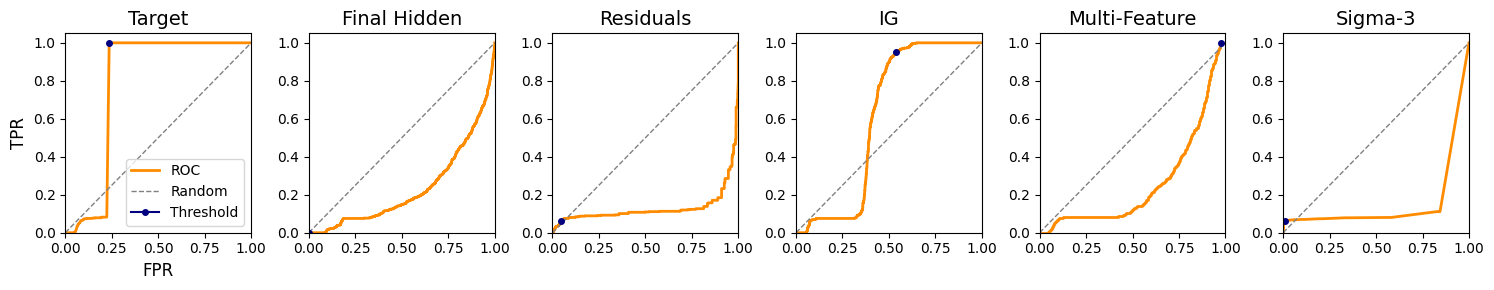

In [68]:
# Visualize the results
# Overall results
fig, axes = plt.subplots(1, len(methods), figsize=(15, 3))
auc_scores = {}
for i, key in enumerate(methods):
    # ROC curve
    fpr, tpr, thresholds = roc_curve(results['Actual'], results[key]['Decision Function'])
    roc_auc = auc(fpr, tpr)
    auc_scores[key] = {'Overall': roc_auc}
    # Find the index based on the optimal threshold
    optimal_threshold = results[key]['Optimal Threshold']
    optimal_index = np.argmin(np.abs(thresholds - optimal_threshold)) # Find the index of the optimal threshold based on smallest difference
    optimal_fpr = fpr[optimal_index]
    optimal_tpr = tpr[optimal_index]
    axes[i] = visualize_roc_auc(axes[i], i, key, fpr, tpr, roc_auc, optimal_fpr, optimal_tpr)
    # remove legend
    if i != 0:
        axes[i].legend().remove()
plt.tight_layout()
plt.savefig(save_folder / 'roc_auc_overall.png')
plt.show()
plt.close()


In [61]:
# For each anomaly
data_label = results['Data Label']
for label in data_label_hue_order[::-1]:
    if label == 'Original':
        continue
    mask = (np.array(data_label) == label) | (np.array(data_label) == 'Original')
    # Create a figure with two subplots side by side
    #fig, axes = plt.subplots(2, len(methods), figsize=(15, 5))
    for i, key in enumerate(methods):
        # # Confusion matrix
        # conf_matrix = confusion_matrix(results['Actual'][mask], results[key]['Predicted'][mask])
        # conf_matrix = conf_matrix.astype('float') / (conf_matrix.sum(axis=1)[:, np.newaxis] + 1e-9) * 100
        # axes[0, i] = visualize_confusion(axes[0, i], i, key, conf_matrix, ".2f", 'Blues')

        # ROC curve
        fpr, tpr, _ = roc_curve(results['Actual'][mask], results[key]['Decision Function'][mask])
        roc_auc = auc(fpr, tpr)
        auc_scores[key][label] = roc_auc
        #axes[1, i] = visualize_roc_auc(axes[1, i], i, ' ', fpr, tpr, roc_auc)

    # plt.tight_layout()
    # plt.savefig(save_folder / f'roc_auc_{label}.png')
    # plt.show()
    # plt.close()
    #print('\n')

/work3/s194262/thesis/lib64/python3.9/site-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/work3/s194262/thesis/lib64/python3.9/site-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/work3/s194262/thesis/lib64/python3.9/site-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/work3/s194262/thesis/lib64/python3.9/site-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/work3/s194262/thesis/lib64/python3.9/site-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


# AUC metric

In [62]:
# row ordering
row_order = data_label_hue_order[1:] + ['Average', 'Overall']

# AUC
auc_df = pd.DataFrame(auc_scores)
# Calculate the average AUC as well
auc_df.loc['Average'] = auc_df.loc[data_label_hue_order[1:]].mean()
auc_df = auc_df.loc[row_order]
visualize_metric_matrix('AUC', auc_df, 'Oranges', 2, suffix=None, figsize=(10, 3), save_folder=save_folder)


# Decision Function

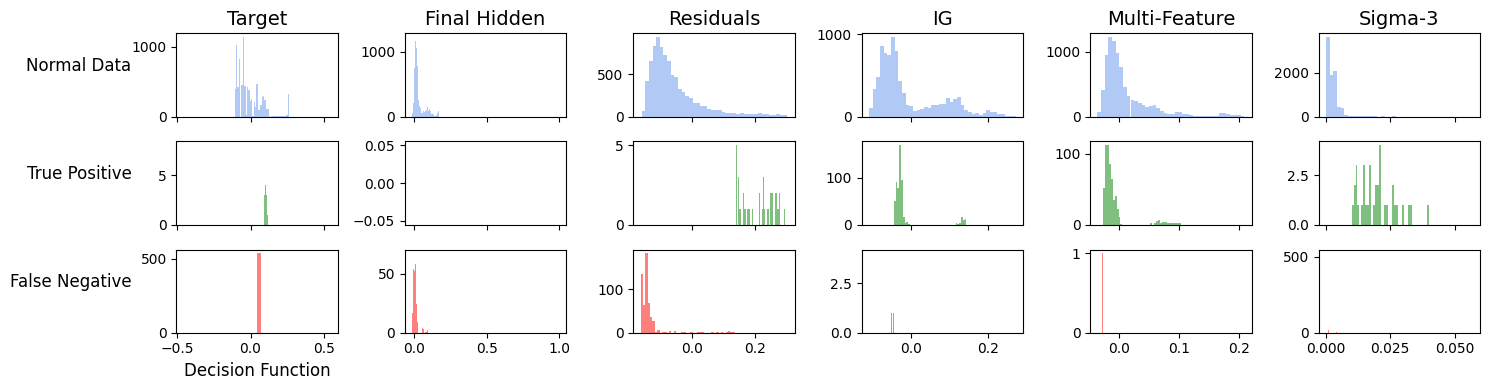

In [104]:
actual = results['Actual']

fig, axes = plt.subplots(3, len(methods), figsize=(15, 4), sharex="col")

# Normal Data, Predicted Synthetic, Not Predicted Synthetic
for i, key in enumerate(methods):
    _predicted_synthetic = (results[key]['Predicted'].astype(int) == 1) & (actual.astype(int) == 1)
    predicted_synthetic = results[key]['Decision Function'][_predicted_synthetic]
    _not_predicted_synthetic = (results[key]['Predicted'].astype(int) == 0) & (actual.astype(int) == 1)
    not_predicted_synthetic = results[key]['Decision Function'][_not_predicted_synthetic]
    _normal_data = (actual.astype(int) == 0)
    normal_data = results[key]['Decision Function'][_normal_data]
    # Visualize the distribution of the decision function
    axes[0, i].hist(normal_data, bins=40, color='cornflowerblue', alpha=0.5)
    axes[1, i].hist(predicted_synthetic, bins=40, color='green', alpha=0.5)
    axes[2, i].hist(not_predicted_synthetic, bins=40, color='red', alpha=0.5)
    axes[0, i].set_title(key, fontsize=14)
    
axes[0, 0].set_ylabel('Normal Data', fontsize=12, rotation=0, labelpad=0, ha='right')
axes[1, 0].set_ylabel('True Positive', fontsize=12, rotation=0, labelpad=0, ha='right')
axes[2, 0].set_ylabel('False Negative', fontsize=12, rotation=0, labelpad=0, ha='right')
axes[2, 0].set_xlabel('Decision Function', fontsize=12)
fig.align_ylabels()  # ensures all y-labels are properly aligned

plt.tight_layout()
plt.savefig(save_folder / 'decision_function_distribution.png')
plt.show()
plt.close()

# Timing and Coverage

In [105]:
from fault_management_uds.synthetic.synthetic_generator import find_unterrupted_sequences

In [141]:
def get_coverage(predicted, anomaly_start_end):
    # Given start and end of anomalies, find how much of the anomaly is covered by the prediction
    # Find all indices where the value is 1
    ones_indices = np.where(predicted == 1)[0]
    # Find the closest index in both directions
    if len(ones_indices) == 0:
        # do not continue
        #raise ValueError("No anomalies detected")
        return [0] * len(anomaly_start_end)

    coverage = []

    for start, end in anomaly_start_end:
        # extract relevant data
        anomaly_data = predicted[start:end+1]
        
        # Coverage
        coverage.append(anomaly_data.sum() / len(anomaly_data))

    return coverage


def get_timing(predicted, anomaly_start_end, direction='start'):
    # Find all indices where the value is 1
    ones_indices = np.where(predicted == 1)[0]

    # Handle case with no detections
    if len(ones_indices) == 0:
        return [0] * len(anomaly_start_end)

    timing = []

    for i, (start, end) in enumerate(anomaly_start_end):
        if direction == 'start':
            # Filter indices that are after the start
            valid_indices = ones_indices[ones_indices > start] # after start
            if valid_indices.size > 0:
                distances = np.abs(valid_indices - start)
                closest_index = valid_indices[np.argmin(distances)]
                timing.append(closest_index - start)
            # else:
            #     timing.append(np.inf)  # Use inf to indicate no proximity
        elif direction == 'end':
            # Filter indices that are before the end
            #valid_indices = ones_indices[ones_indices < end]
            end_threshold = end + 60 # 60 minutes after the end

            valid_indices = ones_indices[(ones_indices > start) & (ones_indices < end_threshold)]
            if valid_indices.size > 0:
                distances = np.abs(valid_indices - end)
                closest_index = valid_indices[np.argmin(distances)]
                timing.append(closest_index - end)
            # else:
            #     timing.append(np.inf)  # Use inf to indicate no proximity
        else:
            raise ValueError("Invalid direction specified. Use 'start' or 'end'.")

    return timing

In [138]:
# Get the start and end of each anomaly
indices_of_ones = [index for index, value in enumerate(results['Actual']) if value == 1]
_, anomaly_start_end = find_unterrupted_sequences(indices_of_ones, 0)

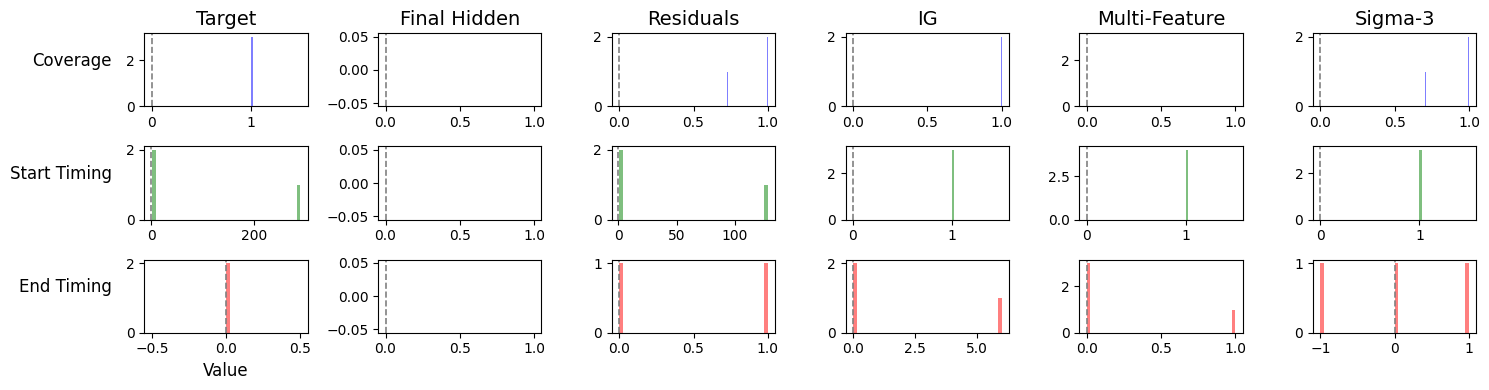

In [ ]:
fig, axes = plt.subplots(3, len(methods), figsize=(15, 4))#, sharey=True)

# Normal Data, Predicted Synthetic, Not Predicted Synthetic
for i, key in enumerate(methods):
    coverage = get_coverage(results[key]['Predicted'], anomaly_start_end)
    _coverage = [cov for cov in coverage if cov > 0]
    # for timing, we only want those that are detected
    _anomaly_start_end = [anomaly_start_end[i] for i, cov in enumerate(coverage) if cov > 0]
    start_timing = get_timing(results[key]['Predicted'], _anomaly_start_end, direction='start')
    end_timing = get_timing(results[key]['Predicted'], _anomaly_start_end, direction='end')

    # Visualize the distribution of the decision function
    axes[0, i].hist(_coverage, bins=40, color='blue', alpha=0.5)
    axes[1, i].hist(start_timing, bins=40, color='green', alpha=0.5)
    axes[2, i].hist(end_timing, bins=40, color='red', alpha=0.5)
    axes[0, i].set_title(key, fontsize=14)
    # Adding vertical line at x = 0
    for ax in axes[:, i]:  # For all three subplots
        ax.axvline(x=0, color='grey', linestyle='--', linewidth=1.2)
        # ax.text(0.05, ax.get_ylim()[1]*0.9, 'Perfect Timing', color='black', fontsize=10,
        #         horizontalalignment='center', verticalalignment='center')  # Add text label

axes[0, 0].set_ylabel('Coverage', fontsize=12, rotation=0, labelpad=10, ha='right')
axes[1, 0].set_ylabel('Start Timing', fontsize=12, rotation=0, labelpad=10, ha='right')
axes[2, 0].set_ylabel('End Timing', fontsize=12, rotation=0, labelpad=10, ha='right')
axes[2, 0].set_xlabel('Value', fontsize=12)
fig.align_ylabels()  # ensures all y-labels are properly aligned

plt.tight_layout()
plt.savefig(save_folder / 'coverage_timing.png')
plt.show()
plt.close()


# Binned Anomaly Intervals

In [170]:
from scipy.interpolate import interp1d


In [191]:
def get_decision_values(results, key, start_end, n_bins=10):

    # Create a fixed number of bins
    normalized_x = np.linspace(0, 1, n_bins)

    # Iterate through each 
    decision_values = []
    for start, end in start_end:
        # extract the decision function values
        decision_segment = results[key]['Decision Function'][start:end+1]

        if len(decision_segment) == 1:
            # If there's only one value, repeat it for all bins
            normalized_decision_values = np.full(n_bins, decision_segment[0])
        else:
            # Original x-coordinates (normalized from 0 to 1)
            original_x = np.linspace(0, 1, len(decision_segment))
            
            # Interpolation function
            interp_func = interp1d(original_x, decision_segment, kind='linear', bounds_error=False, fill_value="extrapolate")
            
            # Resample to fixed 10 points
            normalized_decision_values = interp_func(normalized_x)
        
        decision_values.append(normalized_decision_values)

    return np.array(decision_values)

0.009954430912255027

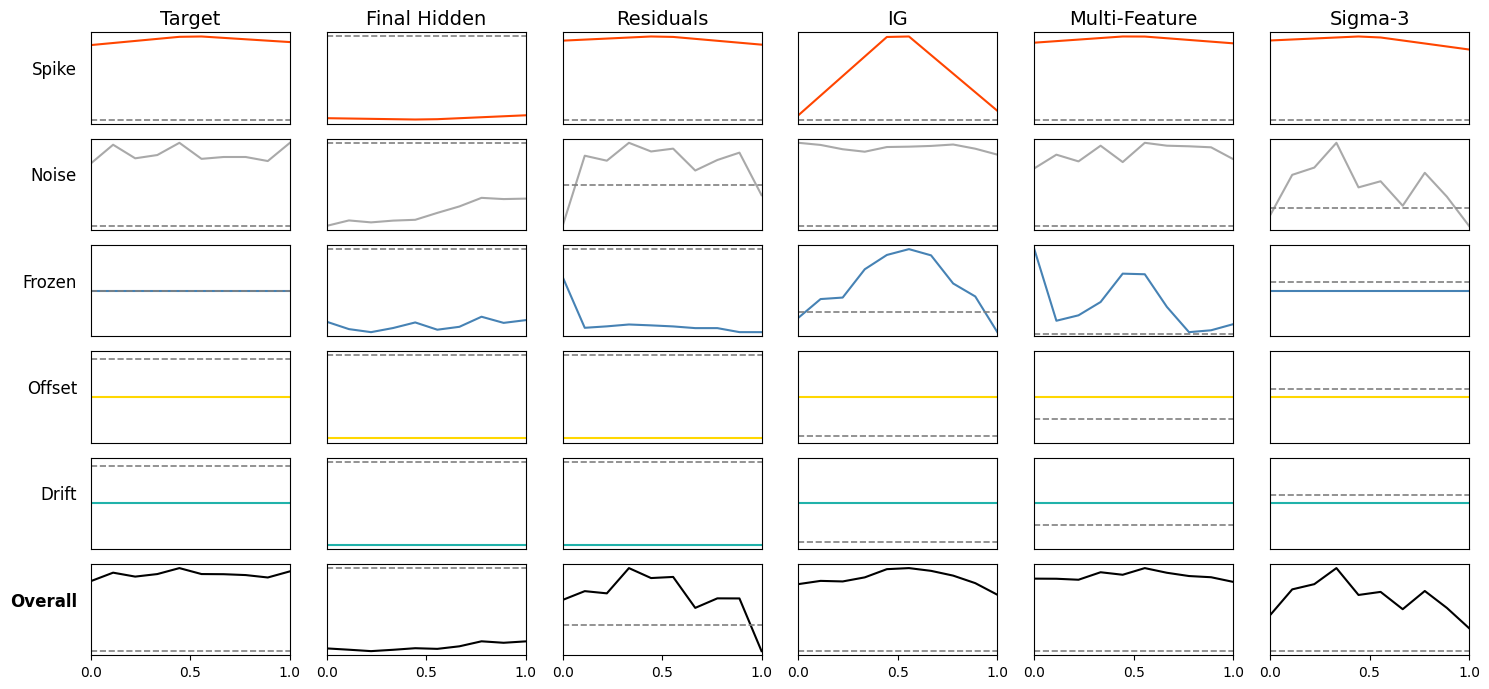

In [198]:
fig, axes = plt.subplots(len(data_label_hue_order), len(methods), figsize=(15, 7))#, sharey=True)

n_bins = 10
normalized_x = np.linspace(0, 1, n_bins)  # Create normalized positions


# For each method
for i, key in enumerate(methods):
    data_label = results['Data Label']
    # For each
    j=0
    for label in data_label_hue_order[::-1]:
        if label == 'Original':
            #continue
            # jsut use this to compute the overall
            label = "Overall"
            mask = np.array(data_label) != 'Original'
            color = 'black'
        else:
            # Anomaly filter
            mask = (np.array(data_label) == label)
            color = data_label_hue_map[label]
        # filter for starts based on the starts in _anomaly_start_end and mask
        start_end = [anomaly_start_end[i] for i, (start, end) in enumerate(anomaly_start_end) if mask[start]]

        # Get the decision values
        decision_values = get_decision_values(results, key, start_end, n_bins)

        # Average the decision values
        average_decision_values = np.mean(decision_values, axis=0) if len(decision_values) > 0 else np.zeros(n_bins)
        # Plot the average decision values as a line
        axes[j, i].plot(normalized_x, average_decision_values, label=label, color=color)
        threshold = results[key]["Optimal Threshold"]
        axes[j, i].axhline(threshold, color='grey', linestyle='--', label='Threshold', linewidth=1.2)
        axes[j, i].set_xlim([0, 1])
        axes[j, i].set_xticks([])
        axes[j, i].set_yticks([])
        if j == 0:
            axes[j, i].set_title(key, fontsize=14)
        if i == 0:
            fontweight = 'bold' if label == 'Overall' else 'normal' 
            axes[j, i].set_ylabel(label, fontsize=12, rotation=0, labelpad=10, ha='right', fontweight=fontweight)
        j+=1
    
    axes[j-1, i].set_xticks([0, 0.5, 1])


plt.tight_layout()
plt.savefig(save_folder / 'decision_values.png')
plt.show()
plt.close()


# Qualitative examples

For:
- Most accurate detections
- Least accurate detections
- Most certain non-anomalies


### Identify detections

### Difference vs. decision function plot

### Feature plot